In [1]:
import os, sys

sys.path.append('..' + os.sep + 'preprocess2')

from common import*

from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

FilterNeurokitWarnings()

In [2]:
BEG_TEST = '..' + os.sep + 'data' + os.sep + 'TestData' + os.sep
BEG_TRAIN = '..' + os.sep + 'preprocess2' + os.sep + PREPROCESSED_DATA + os.sep + '0' + os.sep

dfAgeSex = pd.read_csv(BEG_TEST + 'attributes.csv')
with h5py.File(BEG_TEST + 'ecg_tracings.hdf5') as f:
    M = np.array(f['tracings'])
dfLabels = pd.read_csv(BEG_TEST + 'gold_standard.csv')

def GetTestAge(i):
    return dfAgeSex.values[i][0]

testLabels = dfLabels.values
# deixar as labels na mesma ordem do treino
testLabels[:,4], testLabels[:,5] = testLabels[:,5], testLabels[:,4].copy()

def GetECGAndLabelsInNewAge(ecg, targetAge):
    '''
    retorna o ECG mais próximo no espaço de features na nova idade,
    e as labels dele. Essa função faz tudo do 0 (lê os dados, constrói o modelo (KDTree)),
    então se o mesmo modelo for usado várias vezes, faz sentido parametrizar isso.
    '''
    
    targetAge = min(max(MIN_AGE, targetAge), MAX_AGE)
    
    w = ecg - ecg.mean()
    try:
        d = nk.ecg_delineate(w, sampling_rate=SAMPLE_RATE)[1]
    except:
        raise Exception('Neurokit não conseguiu delinear esse ECG')
    
    starts = d['ECG_P_Onsets']
    coeffs = []
    for j in range(len(starts) - 1):
        cur = starts[j]
        nxt = starts[j + 1]
        if math.isnan(cur) or math.isnan(nxt):
            print('Neurokit retornou nan')
            continue
            
        period = w[cur:nxt]
        if not len(period):
            print('Neurokit retornou período vazio')
            break
            
        coeffs.append(GetCoeff(period))
    
    if not len(coeffs):
        raise Exception('Neurokit não conseguiu encontrar batimentos nesse ECG')
    
    start = BEG_TRAIN + str(targetAge) + os.sep

    mappings = np.load(start + 'mappings.npy')
    ecgs = np.load(start + 'ecgs.npy')
    ondas = np.load(start + 'ondas.npy')
    labels = np.load(start + 'labels.npy')
    
    tree = KDTree(ondas)
    dist, ind = tree.query(coeffs)
    gIdx = dist.argmin()
    idxClosestOnda = ind[gIdx][0]
    ecgOrgRow = mappings[idxClosestOnda]
    ecgClosest = ecgs[ecgOrgRow]
    labelsEcgClosest = labels[ecgOrgRow]
    
    return ecgClosest, labelsEcgClosest

38 [0 0 0 0 0 0]


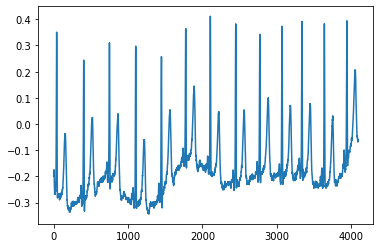

40 [0 0 0 0 0 0]


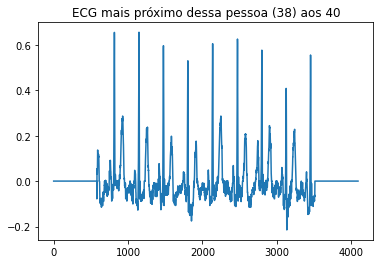

In [6]:
pessoa = 30
ecg = M[pessoa, :, ELETRODO_IDX]
age = GetTestAge(pessoa)
pessoaLabels = testLabels[pessoa]

print(age, pessoaLabels)
plt.plot(ecg)
plt.show()

targetAge = 40
plt.title('ECG mais próximo dessa pessoa (' + str(age) + ') aos ' + str(targetAge))
ecgClosest, labelsEcgClosest = GetECGAndLabelsInNewAge(ecg, targetAge)
print(targetAge, labelsEcgClosest.astype(int))
plt.plot(ecgClosest)
plt.show()

In [4]:
start = BEG_TRAIN + str(targetAge) + os.sep
mappings = np.load(start + 'mappings.npy')
ecgs = np.load(start + 'ecgs.npy')
ondas = np.load(start + 'ondas.npy')
labels = np.load(start + 'labels.npy')

In [5]:
len([i for i in enumerate(labels) if np.any(i[1])])
labels.shape

(265, 6)

(500.0, 1500.0)

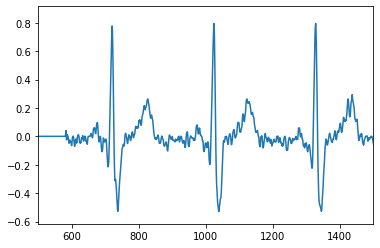

In [6]:
plt.plot(ecgs[118]);plt.xlim(500, 1500)

In [7]:
[i for i in labels if np.all(i == [1, 1, 0, 0, 0, 0])]

[]

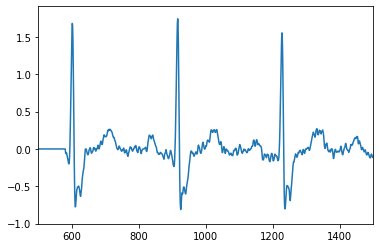

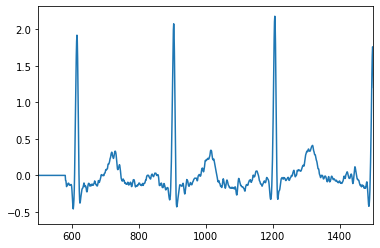

In [8]:
plt.plot(ecg);plt.xlim([500, 1500]);plt.show()
plt.plot(ecgClosest);plt.xlim([500, 1500]);plt.show()

In [ ]:
targetAge = 40

In [13]:
N_TEST = len(M)
matched = []
for i in range(N_TEST):
    
    if i % 50 == 0:
        print(i, '/', N_TEST)
        
    ecg = M[i, :, ELETRODO_IDX]
    pessoaLabels = testLabels[i]
    
    def get():
        try:
            return GetECGAndLabelsInNewAge(ecg, targetAge)[1]
        except:
            print('Erro no ECG', i)
            return None
    labelsEcgClosest = get()
    if labelsEcgClosest is not None:
        matched.append(pessoaLabels == labelsEcgClosest)
    
matched = np.array(matched, dtype=int)

0 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
50 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
100 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
150 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
200 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
250 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
300 / 827
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit retornou nan
Neurokit 

In [14]:
matched

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1]])

In [15]:
(matched.sum(axis=1)==6).sum() # número de pessoas com as mesmas labels exatas

685

In [18]:
# pessoas com algum 1 que tiveram match 100%
idx = []
for i in range(len(matched)):
    if testLabels[i].sum():
        if matched[i].sum() == 6:
            idx.append(i)
idx

[23,
 33,
 69,
 108,
 128,
 137,
 178,
 184,
 247,
 298,
 365,
 376,
 379,
 397,
 417,
 446,
 458,
 463,
 469,
 481,
 485,
 489,
 493,
 495,
 498,
 501,
 514,
 522,
 525,
 534,
 541,
 543,
 545,
 548,
 553,
 555,
 564,
 572,
 574,
 579,
 581,
 594,
 613,
 618,
 626,
 629,
 659,
 662,
 667,
 672,
 683,
 687,
 695,
 712,
 718,
 721,
 723,
 725,
 730,
 744,
 747,
 753,
 759,
 767,
 787,
 790]

In [ ]:
matched

In [ ]:
(matched.sum(axis=1)==6).sum() # número de pessoas com as mesmas labels exatas